# Change points detection algorithm
- From MoSeq
- Basseville, M., and Nikiforov, I.V. (1993). Detection of abrupt changes (Prentice-Hall Publishing).

In [133]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from scipy.ndimage import gaussian_filter1d

from one.api import ONE
one = ONE()


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [3]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

### Parameters
Need to do grid-search on this

In [135]:
k = 4  # bin lag for derivative calculation
h = 01.5  # thresold??
sigma = 0.43  # for Gaussian filter

### TODO:
- dimensionality reduction
- derivative of the per-frame unit-normalized projections
- thresold and sum; 1D binary result
- Gaussian smoothing
- changepoint detection via local maxima identification
- grid search to find parameters that yield no changepoints on control (shuffled) dataset

## PCA on data samples

In [283]:
"""
PRINCIPLE COMPONENT ANALYSES
"""

X = matrix_all[mat][0] # (n_samples, n_features)
#X = np.array(design_matrix)

# Mean centered and equal variance (redundant code)
scaler = StandardScaler()
scaler.fit(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaler.transform(X))
#X_reduced = pca.fit_transform(X)


Text(0, 0.5, '% Variance explained')

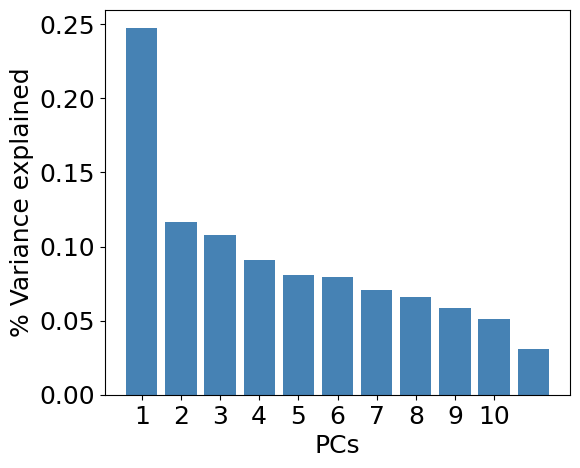

In [284]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = np.shape(X)[1]
plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
plt.xticks(np.arange(1, keep_pc, 1))
#plt.xlim([0, 3])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

In [285]:
# Normalize PC projections
scaler = StandardScaler()

# Fit and transform the data
normalized_projections = scaler.fit_transform(X_reduced)  # TODO: is projections the accurate term here?
normalized_projections = scaler.fit_transform(X)


### Get bin information

In [286]:
# Plot projections of datapoints into first 3 principal components
augmented_data = pd.DataFrame(columns=['Bin'], index=range(len(normalized_projections)))
augmented_data['Bin'] = design_matrix['Bin']
augmented_data['pc1'] = normalized_projections[:, 0].transpose()
augmented_data['pc2'] = normalized_projections[:, 1].transpose()
augmented_data['pc3'] = normalized_projections[:, 2].transpose()
augmented_data['pc4'] = normalized_projections[:, 3].transpose()
augmented_data['pc5'] = normalized_projections[:, 4].transpose()
augmented_data['pc6'] = normalized_projections[:, 5].transpose()
augmented_data['pc7'] = normalized_projections[:, 6].transpose()
augmented_data['pc8'] = normalized_projections[:, 7].transpose()
augmented_data['pc9'] = normalized_projections[:, 8].transpose()
augmented_data['pc10'] = normalized_projections[:, 9].transpose()

### Derivative

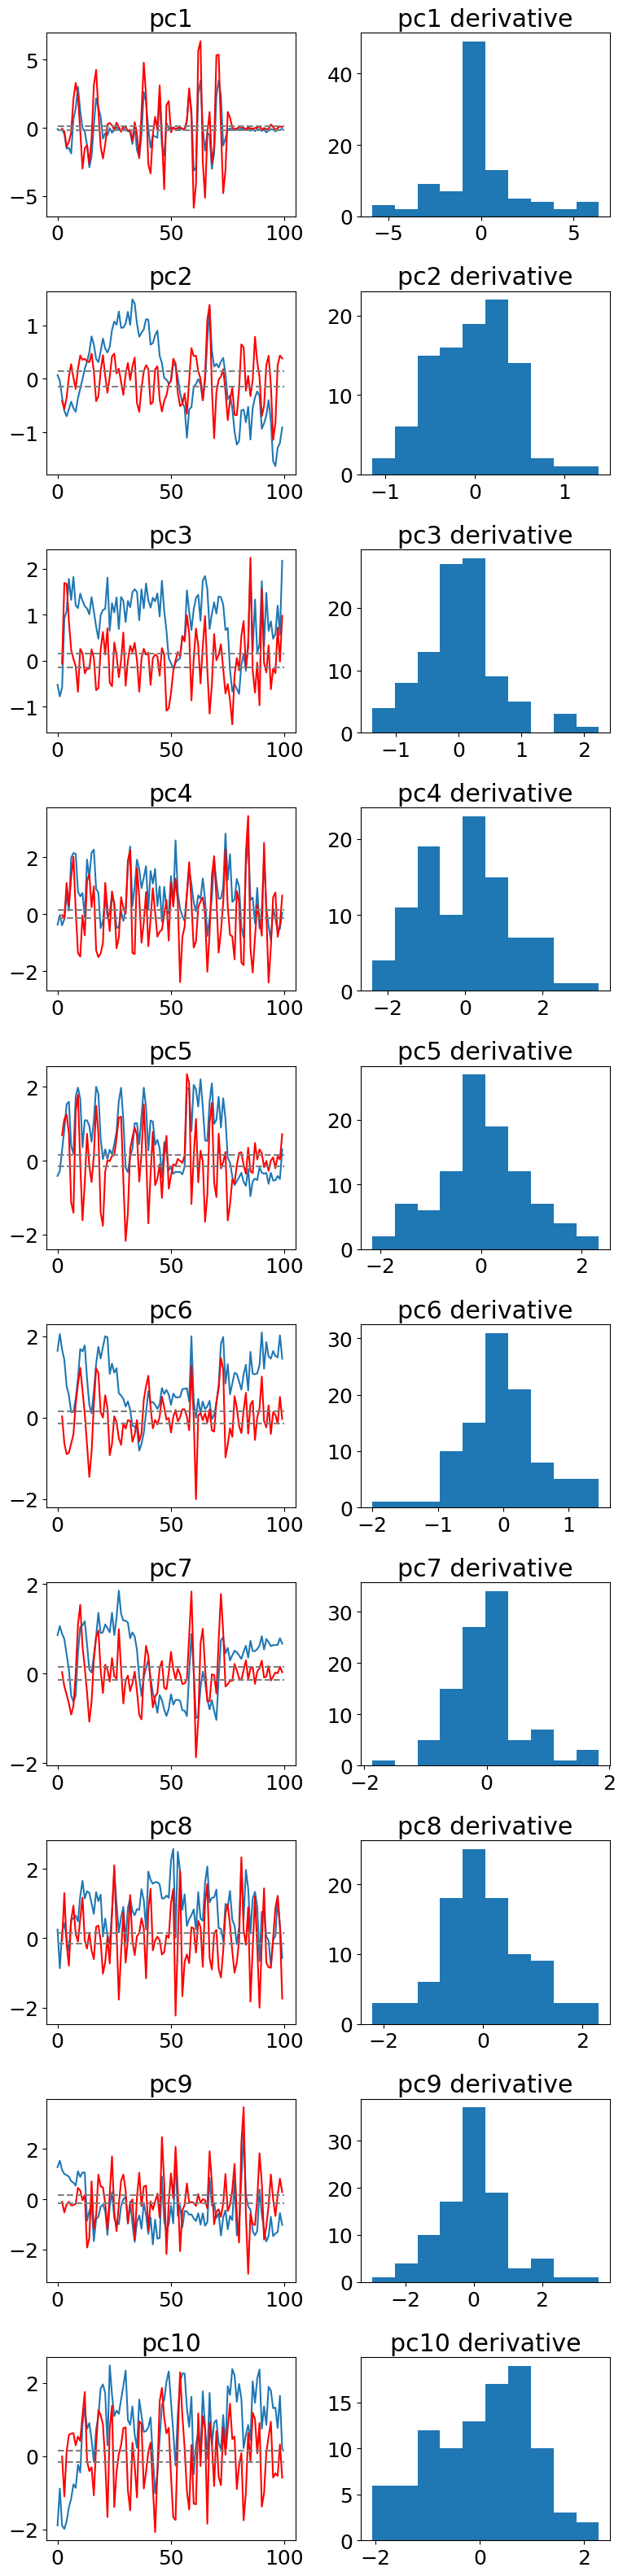

In [287]:
derivative = augmented_data.copy()
pcs = augmented_data.keys()[1:]

min = 0
max = 100

fig, ax = plt.subplots(nrows=len(pcs) , ncols=2, sharex=False, sharey=False, figsize=[8, 32])

for i, pc in enumerate(pcs):
    derivative[pc] = derivative[pc] - derivative[pc].shift(k)    
    
    ax[i, 0].plot(augmented_data[pc][min:max])
    ax[i, 0].plot(derivative[pc][min:max], color='red')
    ax[i, 0].hlines(h, min, max, linestyles='--', color='Gray')
    ax[i, 0].hlines(-h, min, max, linestyles='--', color='Gray')
    ax[i, 1].hist(derivative[pc][min:max])
    ax[i, 0].set_title(pc)
    ax[i, 1].set_title(str(pc + ' derivative'))

plt.tight_layout()


### Thresholding

In [288]:
thresholded = derivative[np.array(pcs)]

for i, pc in enumerate(pcs):
    # thresholded[pc] = thresholded[pc] * np.nan
    thresholded.loc[(thresholded[pc] >= -h) & (thresholded[pc] <= h), pc] = 0
    thresholded.loc[thresholded[pc] > h, pc] = 1
    thresholded.loc[thresholded[pc] < -h, pc] = 1
    
summed_thresold = np.sum(thresholded, axis=1)
overall_thresold = np.array(summed_thresold)
overall_thresold[np.where(summed_thresold>=5)] = 1
overall_thresold[np.where(summed_thresold<5)] = 0

/tmp/ipykernel_17460/2471855153.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[(thresholded[pc] >= -h) & (thresholded[pc] <= h), pc] = 0
/tmp/ipykernel_17460/2471855153.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[thresholded[pc] > h, pc] = 1
/tmp/ipykernel_17460/2471855153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[thresholded[pc] < -h, pc] = 1


### Gaussian filter

In [289]:
# Apply Gaussian filter
smoothed_signal = gaussian_filter1d(overall_thresold, sigma=sigma)

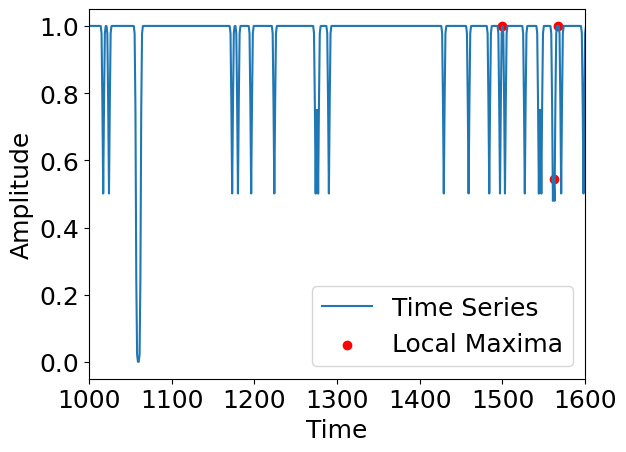

In [290]:
local_maxima = argrelextrema(smoothed_signal, np.greater)

time = augmented_data['Bin']
# Plot the time series and local maxima
plt.plot(time, smoothed_signal, label='Time Series')
plt.scatter(time[local_maxima[0]], smoothed_signal[local_maxima[0]], color='red', label='Local Maxima')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([1000, 1600])
plt.show()

### Control data

In [302]:
shuffled_data = augmented_data.copy()[np.array(pcs)]
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)

### Grid serach

In [171]:
def changepoint_detection(data, k, h, sigma):
    
    # Find first derivative
    derivative = data.copy()
    pcs = data.keys()[1:]
    for i, pc in enumerate(pcs):
        derivative[pc] = derivative[pc] - derivative[pc].shift(k)    
    
    # Thresold derivative
    thresholded = derivative[np.array(pcs)]

    for i, pc in enumerate(pcs):
        # thresholded[pc] = thresholded[pc] * np.nan
        thresholded.loc[(thresholded[pc] >= -h) & (thresholded[pc] <= h), pc] = 0
        thresholded.loc[thresholded[pc] > h, pc] = 1
        thresholded.loc[thresholded[pc] < -h, pc] = 1
        
    summed_thresold = np.sum(thresholded, axis=1)
    overall_thresold = np.array(summed_thresold)
    overall_thresold[np.where(summed_thresold>=5)] = 1
    overall_thresold[np.where(summed_thresold<5)] = 0
    
    # Apply Gaussian filter
    smoothed_signal = gaussian_filter1d(overall_thresold, sigma=sigma)
    
    # Detect changepoints
    local_maxima = argrelextrema(smoothed_signal, np.greater)
    smoothed_signal[local_maxima[0]]
    
    return local_maxima

In [296]:
ks = [2, 3, 4, 5, 6, 7]  # bin lag for derivative calculation
hs = [0.06, 0.08, 0.1, 0.12, 0.14, 0.15, 0.2, 0.5, 1, 1.5, 2, 2,5]  # thresold??
sigmas = [0.1, 0.2, 0.3, 0.43, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # for Gaussian filter

results_data = {}
results_control ={}
summary_results = {}

for ik, k in enumerate(ks):
    results_data[k] = {}
    results_control[k] = {}
    summary_results[k] = {}
    
    for ih, h in enumerate(hs):
        results_data[k][h] = {}
        results_control[k][h] = {}
        summary_results[k][h] = {}
        
        for isig, sigma in enumerate(sigmas):
            
            """ Data """
            data_changepoints = changepoint_detection(augmented_data, k, h, sigma)
            
            """ Control """
            shuffled_data = augmented_data.copy()[np.array(pcs)]
            shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)
            shuffled_changepoints = changepoint_detection(shuffled_data, k, h, sigma)
            
            """ Save results """
            results_data[k][h][sigma] = data_changepoints 
            results_control[k][h][sigma] = shuffled_changepoints 
            summary_results[k][h][sigma] = [len(data_changepoints[0]), len(shuffled_changepoints[0])]


/tmp/ipykernel_17460/2763128134.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[(thresholded[pc] >= -h) & (thresholded[pc] <= h), pc] = 0
/tmp/ipykernel_17460/2763128134.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[thresholded[pc] > h, pc] = 1
/tmp/ipykernel_17460/2763128134.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[thresholded[pc] < -h, pc] = 1
/tmp/ipykernel_1746

In [297]:
#max_changepoints = {}
max_changepoints = []
keys = []
for ik, k in enumerate(ks):
    
    for ih, h in enumerate(hs):
        
        for isig, sigma in enumerate(sigmas):
            if summary_results[k][h][sigma][1] == 0:

                if len(max_changepoints) == 0:
                    max_changepoints = [summary_results[k][h][sigma][0]]
                    keys = [k, h, sigma]
                else:
                    max_changepoints = np.vstack((max_changepoints, summary_results[k][h][sigma][0]))
                    keys = np.vstack((keys, [k, h, sigma]))


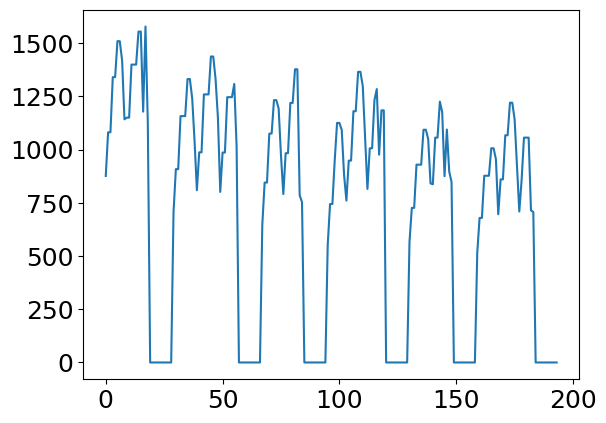

In [298]:
plt.plot(max_changepoints)

In [300]:
flat_changepoints = max_changepoints.ravel()
keys[flat_changepoints==np.max(flat_changepoints)]

array([[2. , 0.1, 0.8]])

### Optimal changepoints

In [301]:
# Best on PC projections
k = 2
h = 0.15
sigma = 0.8

# Best on raw data
k = 2
h = 0.1
sigma = 0.8

data_changepoints = changepoint_detection(augmented_data, k, h, sigma)


/tmp/ipykernel_17460/2763128134.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[(thresholded[pc] >= -h) & (thresholded[pc] <= h), pc] = 0
/tmp/ipykernel_17460/2763128134.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[thresholded[pc] > h, pc] = 1
/tmp/ipykernel_17460/2763128134.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thresholded.loc[thresholded[pc] < -h, pc] = 1


(0.0, 50.0)

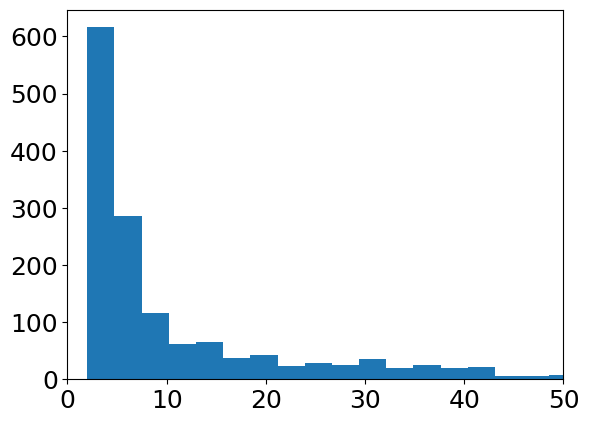

In [303]:
plt.hist(np.diff(data_changepoints[0]), bins=400)
plt.xlim([0, 50])

In [304]:
np.median(np.diff(data_changepoints[0]))

6.0

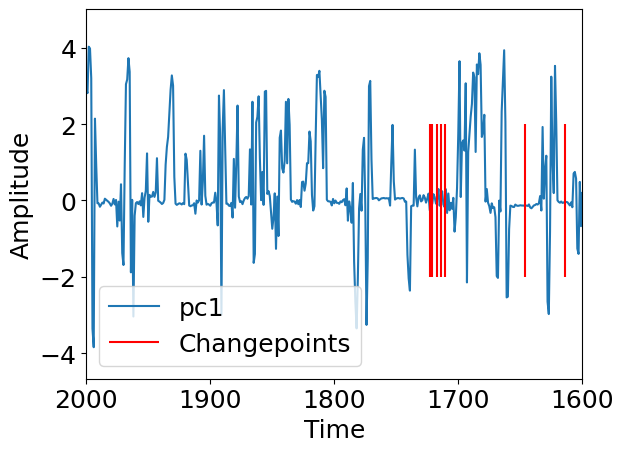

In [305]:
pc = 'pc1'
time = augmented_data['Bin']
# Plot the time series and local maxima
plt.plot(time, augmented_data[pc], label=pc)
plt.vlines(np.array(time)[data_changepoints], -2, 2, color='red', label='Changepoints')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([2000, 1600])
plt.show()

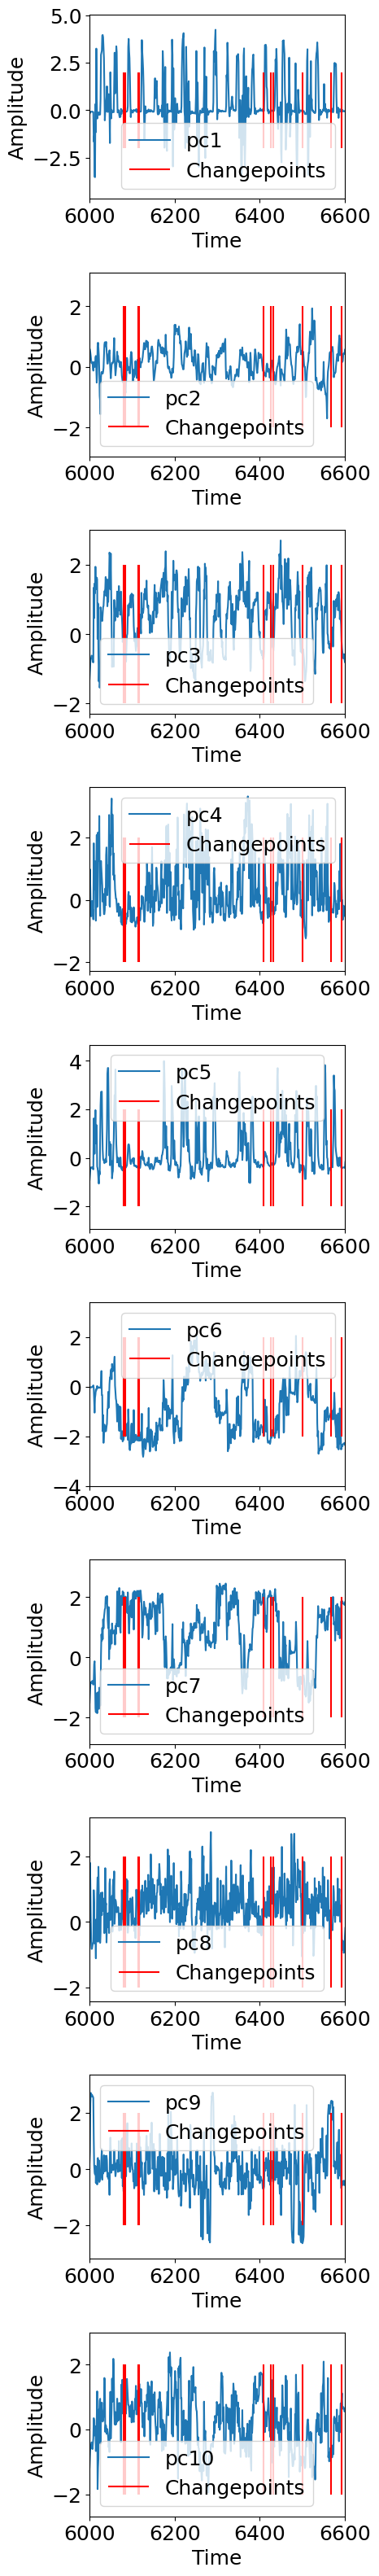

In [319]:
derivative = augmented_data.copy()
pcs = augmented_data.keys()[1:]

min = 6000
max = min + 600

fig, ax = plt.subplots(nrows=len(pcs) , ncols=1, sharex=False, sharey=False, figsize=[5, 32])

for i, pc in enumerate(pcs):
    
    #time = augmented_data['Bin']
    time = np.arange(0, len(augmented_data['Bin']), 1)
    # Plot the time series and local maxima
    ax[i].plot(time, augmented_data[pc], label=pc)
    ax[i].vlines(data_changepoints, -2, 2, color='red', label='Changepoints')
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Amplitude')
    ax[i].set_xlim([min, max])
    
plt.tight_layout()
